In [8]:
import pandas as pd
import numpy as np
import torch
import torch.utils.data as Data
import torch.nn as nn
import torch.optim as optim
import math
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from torch.autograd import Variable
from sklearn import metrics
import torch.nn.utils.weight_norm as weight_norm
from torch.nn import functional as F

In [9]:
class my_Dataset(Data.Dataset):
    def __init__(self, features, labels):
        self.X = features
        self.y = labels

    def __getitem__(self, index):
        return self.X[index], self.y[index]

    def __len__(self):
        return self.X.shape[0]

class WheelRailTrajectoryDataset:
    def __init__(self,label=3):
        standard_scaler = StandardScaler()
        self.raw_data1 = pd.read_csv("../dataset/curve_R400.csv")
        self.raw_data2 = pd.read_csv("../dataset/curve_R1000.csv")
        self.raw_data3 = pd.read_csv("../dataset/curve_R2000.csv")
        self.raw_data4 = pd.read_csv("../dataset/curve_R3000.csv")
        self.raw_data5 = pd.read_csv("../dataset/curve_R4000.csv")
        self.raw_data6 = pd.read_csv("../dataset/curve_R5000.csv")
        self.raw_data = pd.concat([self.raw_data1,self.raw_data2,self.raw_data3,self.raw_data4,self.raw_data5,self.raw_data6])
        self.label = label
        #标准化
        self.data = standard_scaler.fit_transform(self.raw_data)
        self.mean = standard_scaler.mean_[label]
        self.sd = math.sqrt(standard_scaler.var_[label])


    def construct_set(self, train_por=0.6,val_por=0.2,test_por=0.2, window_size=100):
        X = []
        Y = []
        list = [self.raw_data1.shape[0],self.raw_data2.shape[0],self.raw_data3.shape[0],self.raw_data4.shape[0],self.raw_data5.shape[0],self.raw_data6.shape[0]]
        num = 0
        for j in range(len(list)):
            if j!=0:
                num = num+list[j-1]
            for i in range(list[j]-window_size):
                seq = self.data[num+i:num+i+window_size+1]
                X.append(seq[0:window_size,:self.label])
                y = seq[window_size:window_size+1,self.label]
                if(y>0.6 or y<-0.6):
                    Y.append(1)
                else:
                    Y.append(0)
        X = np.array(X)
        Y = np.array(Y)
        print(X.shape)
        print(Y.shape)
        train_x,test_x,train_y,test_y = train_test_split(X,Y,test_size=test_por,train_size=train_por+val_por,shuffle=True)
        train_x,val_x,train_y,val_y =  train_test_split(train_x,train_y,test_size=val_por/(val_por+train_por),train_size=train_por/(val_por+train_por),shuffle=True)

        train_set = my_Dataset(torch.Tensor(train_x), torch.Tensor(train_y))
        val_set = my_Dataset(torch.Tensor(val_x), torch.Tensor(val_y))
        test_set = my_Dataset(torch.Tensor(test_x), torch.Tensor(test_y))
        return train_set, val_set, test_set

TrajectoryData = WheelRailTrajectoryDataset()
train_set, val_set, test_set = TrajectoryData.construct_set()
batch_size = 256
train_loader = Data.DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=0, drop_last=True)
val_loader = Data.DataLoader(val_set, batch_size=batch_size, shuffle=False, num_workers=0, drop_last=True)
test_loader = Data.DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=0, drop_last=True)

(227406, 100, 3)
(227406,)


In [10]:
class Chomp1d(nn.Module):
    def __init__(self,chomp_size):
        super(Chomp1d, self).__init__()
        self.chomp_size = int(chomp_size)
    def forward(self,x):
        return x[:,:,0:-self.chomp_size].contiguous()

class TCNResidualBlock(nn.Module):
    def __init__(self,inchannel,outchannel,kernelsize,dilation):
        super(TCNResidualBlock,self).__init__()
        self.ke = int(kernelsize+(kernelsize-1)*(dilation-1))
        self.conv = nn.Sequential(
            weight_norm(nn.Conv1d(inchannel,outchannel,kernel_size=kernelsize,dilation=dilation,padding=self.ke-1)),
            Chomp1d(self.ke-1),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.2),
            weight_norm(nn.Conv1d(outchannel,outchannel,kernel_size=kernelsize,dilation=dilation,padding=self.ke-1)),
            Chomp1d(self.ke-1),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.2),
        )
        self.conv1x1 = nn.Sequential(
            weight_norm(nn.Conv1d(inchannel,outchannel,kernel_size=1)),
        )

    def forward(self,X):
        Y = self.conv(X)
        #print("Y:",Y.shape)
        X = self.conv1x1(X)
        #print("X:",X.shape)
        out = F.relu(X+Y)
        return out

In [11]:
class TCNet(nn.Module):
    def __init__(self,seq_len,inchannels,outchannels,kernel_size,dilations):
        super(TCNet,self).__init__()
        self.features = nn.Sequential(
            TCNResidualBlock(inchannel=inchannels[0],outchannel=outchannels[0],kernelsize=kernel_size[0],dilation=dilations[0]),
            TCNResidualBlock(inchannel=inchannels[1],outchannel=outchannels[1],kernelsize=kernel_size[1],dilation=dilations[1]),
            TCNResidualBlock(inchannel=inchannels[2],outchannel=outchannels[2],kernelsize=kernel_size[2],dilation=dilations[2])
        )
        self.projection = nn.Linear(seq_len,1)
        self.classifier = nn.Sequential(
            nn.Linear(in_features=3,out_features=48),
            nn.LeakyReLU(),
            nn.Linear(in_features=48,out_features=2),
            nn.Sigmoid()
        )
        for param in self.parameters():
            if param.dim() > 1:
                nn.init.xavier_uniform_(param)
    def forward(self,X):
        #in_channels代表输入序列的特征维数
        #数据集输入为batch_size * seq_length * features
        #Conv1d要求输入为batch_size*features*seq_length
        X = X.permute(0,2,1).contiguous()
        #print("X:",X.shape)
        features = self.features(X)
        #batch_size*features(output_features)*seq_length 类似LSTM的H矩阵
        out = self.projection(features)
        out = out.squeeze()
        #batch_size*features*pred_len
        out = self.classifier(out)
        #batch_size*pred_len*features
        return out

In [12]:
def evaluate_accuracy(data_iter, net, loss,device="cuda"):
    acc_sum, n = 0.0, 0
    test_l_sum = 0.0
    for X, y in data_iter:
        X = X.to(device)
        y = y.to(device)
        y_hat = net(X)
        y_hat = y_hat.squeeze()
        acc_sum += (y_hat.argmax(dim=1) == y).sum().item()
        l = loss(y_hat, y.long()).sum()
        test_l_sum += l.item()
        n += y.shape[0]
    return acc_sum/n, test_l_sum/n

def train(net,train_iter,val_iter,loss,num_epochs,optimizer,device="cuda"):
    net.train()
    train_loss=[]
    val_loss=[]
    train_accuracy=[]
    val_accuracy=[]
    val_acc_best = 1e-9
    for epoch in range(num_epochs):
        train_l_sum,train_acc_sum,n=0.0,0.0,0
        for X,y in train_iter:
            X = X.to(device)
            #print("X:",X.shape)
            y = y.to(device)
            #print("y:",y.shape) 
            y_hat = net(X)
            #print("y_hat:",y_hat.shape)
            #y_hat = y_hat.squeeze()
            #print("y_hat_squeeze:",y_hat.shape)
            l=loss(y_hat,y.long()).sum()
            optimizer.zero_grad()
            l.backward()
            optimizer.step()
            train_l_sum+=l.item()
            train_acc_sum+=(y_hat.argmax(dim=1)==y).sum().item()
            n+=y.shape[0]
        net.eval()
        val_acc,val_l = evaluate_accuracy(val_iter,net,loss)
        net.train()
        train_loss.append(train_l_sum/n)
        val_loss.append(val_l)
        train_accuracy.append(train_acc_sum/n)
        val_accuracy.append(val_acc)
        if(val_acc>val_acc_best):
            val_acc_best = val_acc
            train_loss_best = train_l_sum/n
            train_acc_best = train_acc_sum/n
            epoch_best = epoch
            torch.save(net.state_dict(),"../weights/ICNet_best.pt")
        print('epoch%d,loss%.4f,train acc %3f,val acc %.3f'%(epoch+1,train_l_sum/n,train_acc_sum/n,val_acc))
    print("best weight was found in epoch%d,where the train loss is %.4f,train acc is %3f,val acc is %.3f"%(epoch_best,train_loss_best,train_acc_best,val_acc_best))
    return train_loss,val_loss,train_accuracy,val_accuracy


def visualization(train_loss,val_loss,train_accuracy,val_accuracy):
    plt.figure(1)
    x1=np.linspace(0,len(train_loss),len(train_loss))
    plt.plot(x1,train_loss,label='train_loss',linewidth=1.5)
    plt.plot(x1,val_loss,label='test_loss',linewidth=1.5)
    plt.xlabel("epoch")
    plt.ylabel("loss")
    plt.legend()
    plt.show()

    plt.figure(2)
    x2 = np.linspace(0,len(train_accuracy),len(train_accuracy))
    plt.plot(x2,train_accuracy,label='train_accuracy',linewidth=1.5)
    plt.plot(x2,val_accuracy,label='val_accuracy',linewidth=1.5)
    plt.xlabel("epoch")
    plt.ylabel("accuracy")
    plt.legend()
    plt.show()

In [13]:
device = torch.device("cuda")
lr = 0.001
epochs=150
loss=nn.CrossEntropyLoss()
net = TCNet(seq_len=100,inchannels=[train_set.X.shape[-1],train_set.X.shape[-1]*2,train_set.X.shape[-1]*4],outchannels=[train_set.X.shape[-1]*2,train_set.X.shape[-1]*4,train_set.X.shape[-1]],kernel_size=[7,5,3],dilations=[1,2,4])
net.to(device)
optimizer=optim.Adam(net.parameters(),lr)

C:\Users\user\AppData\Roaming\Python\Python311\site-packages\torch\nn\utils\weight_norm.py:30: UserWarning: torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.
  warnings.warn("torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.")


In [14]:
train_loss,val_loss,train_accuracy,val_accuracy=train(net,train_loader,val_loader,loss,epochs,optimizer)

epoch1,loss0.0027,train acc 0.583566,val acc 0.588
epoch2,loss0.0027,train acc 0.585189,val acc 0.588
epoch3,loss0.0027,train acc 0.585115,val acc 0.588
epoch4,loss0.0027,train acc 0.585115,val acc 0.588
epoch5,loss0.0027,train acc 0.585122,val acc 0.588
epoch6,loss0.0027,train acc 0.585108,val acc 0.588
epoch7,loss0.0027,train acc 0.585086,val acc 0.588
epoch8,loss0.0027,train acc 0.585115,val acc 0.588
epoch9,loss0.0027,train acc 0.585240,val acc 0.588
epoch10,loss0.0027,train acc 0.585152,val acc 0.588
epoch11,loss0.0027,train acc 0.585049,val acc 0.588
epoch12,loss0.0027,train acc 0.585108,val acc 0.588


KeyboardInterrupt: 

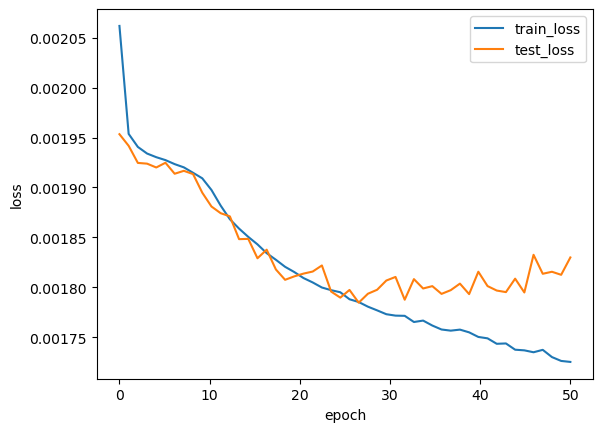

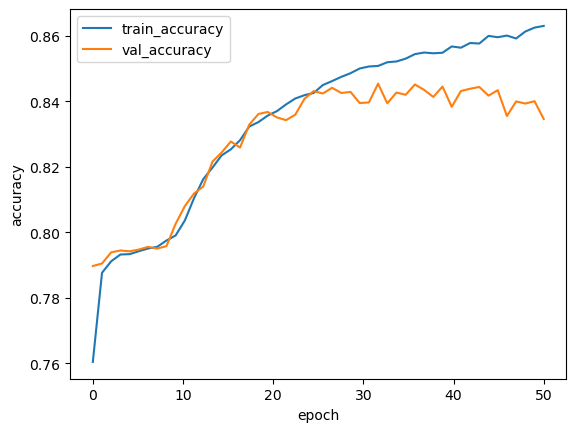

In [12]:
visualization(train_loss,val_loss,train_accuracy,val_accuracy)

In [13]:
net.load_state_dict(torch.load("../weights/TCNet_best.pt"))
test_acc,_ = evaluate_accuracy(test_loader,net,loss)
print("在测试集上的准确率为:%.3f"%(test_acc))

在测试集上的准确率为:0.849


In [14]:
def evaluate_PR(data_iter, net, loss,device="cuda"):
    n = 0
    precision_sum,recall_sum,f1_score_sum = 0.0,0.0,0.0
    test_l_sum = 0.0
    for X, y in data_iter:
        X = X.to(device)
        y = y.to(device)
        y_hat = net(X)
        l = loss(y_hat, y.long()).sum()
        y_hat = y_hat.argmax(dim=1)
        y_hat = y_hat.squeeze().cpu().detach().numpy()
        y = y.cpu().detach().numpy()
        precision_sum += metrics.precision_score(y,y_hat)
        recall_sum += metrics.recall_score(y,y_hat)
        f1_score_sum += metrics.f1_score(y,y_hat)
        test_l_sum += l.item()
        #n += y.shape[0]
        n+=1
    return precision_sum/n,recall_sum/n,f1_score_sum/n
test_precision,test_recall,test_f1_score = evaluate_PR(test_loader,net,loss)
print("test precision:",test_precision," test recall:",test_recall," test f1_score:",test_f1_score)

test precision: 0.8472087909248647  test recall: 0.7786658895240488  test f1_score: 0.8107493792636258
